In [77]:
import numpy as np
import pandas as pd
import yfinance as yf

In [78]:
stock_symbol = 'TCS.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [79]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-08-12,38.724998,40.000000,38.724998,39.700001,28.121277,212976
2002-08-13,39.750000,40.387501,38.875000,39.162498,27.740549,153576
2002-08-14,39.250000,39.250000,35.724998,36.462502,25.828012,822776
2002-08-15,36.462502,36.462502,36.462502,36.462502,25.828012,0
2002-08-16,36.275002,38.000000,35.750000,36.375000,25.766035,811856
...,...,...,...,...,...,...
2024-04-25,3811.199951,3873.649902,3811.000000,3852.199951,3852.199951,2856271
2024-04-26,3855.149902,3876.800049,3802.550049,3821.350098,3821.350098,2039178
2024-04-29,3838.000000,3877.800049,3819.199951,3870.199951,3870.199951,1110693


In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [81]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [82]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [83]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
167/167 [==============================] - 8s 13ms/step - loss: 0.0048
Epoch 2/50
167/167 [==============================] - 4s 25ms/step - loss: 0.0018
Epoch 3/50
167/167 [==============================] - 4s 23ms/step - loss: 0.0015
Epoch 4/50
167/167 [==============================] - 2s 12ms/step - loss: 0.0014
Epoch 5/50
167/167 [==============================] - 2s 11ms/step - loss: 0.0014
Epoch 6/50
167/167 [==============================] - 2s 12ms/step - loss: 0.0012
Epoch 7/50
167/167 [==============================] - 2s 12ms/step - loss: 0.0011
Epoch 8/50
167/167 [==============================] - 2s 13ms/step - loss: 0.0010
Epoch 9/50
167/167 [==============================] - 2s 14ms/step - loss: 0.0010
Epoch 10/50
167/167 [==============================] - 2s 12ms/step - loss: 9.7731e-04
Epoch 11/50
167/167 [==============================] - 2s 12ms/step - loss: 9.6864e-04
Epoch 12/50
167/167 [==============================] - 2s 12ms/step - loss: 8.7105e-04
E

1/1 [==============================] - 0s 21ms/step


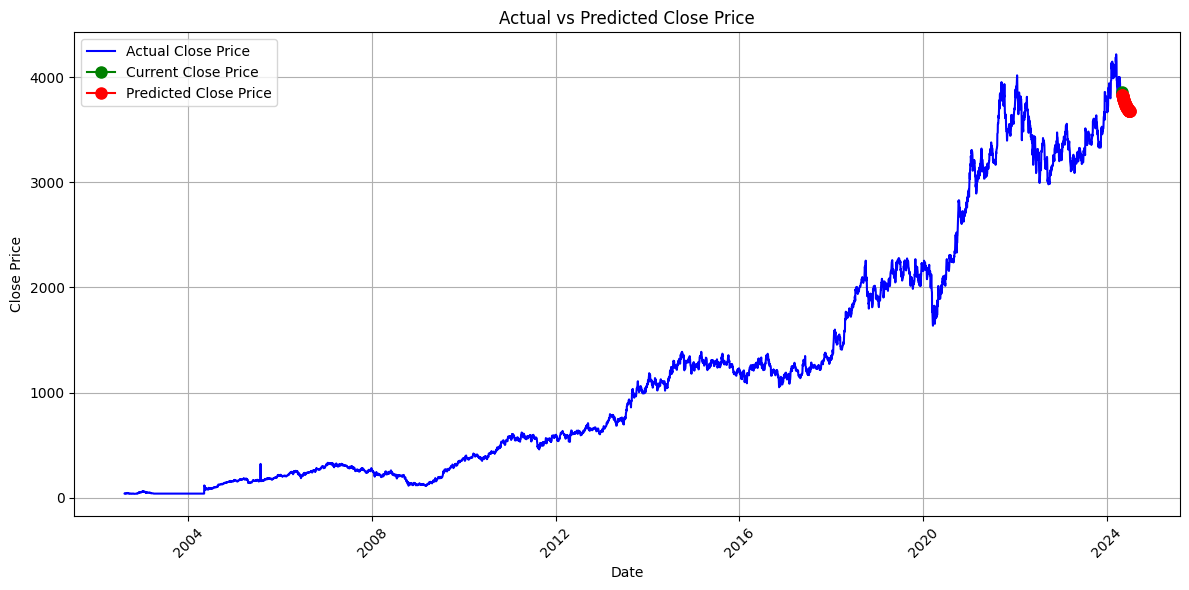

In [84]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
predicted_prices

array([3832.1802, 3829.731 , 3825.3325, 3819.8892, 3814.1658, 3808.5872,
       3803.3372, 3798.456 , 3793.9146, 3789.6577, 3785.6274, 3781.7742,
       3778.059 , 3774.4546, 3770.9429, 3767.5127, 3764.157 , 3760.8743,
       3757.6628, 3754.5232, 3751.4556, 3748.46  , 3745.5364, 3742.6846,
       3739.9033, 3737.1914, 3734.547 , 3731.9688, 3729.4548, 3727.003 ,
       3724.6118, 3722.279 , 3720.0037, 3717.7834, 3715.617 , 3713.5024,
       3711.4392, 3709.4253, 3707.4592, 3705.5405, 3703.6672, 3701.8384,
       3700.0527, 3698.3093, 3696.607 , 3694.9448, 3693.3213, 3691.736 ,
       3690.1877, 3688.6755, 3687.1987, 3685.756 , 3684.347 , 3682.9705,
       3681.6257, 3680.312 , 3679.0286, 3677.7747, 3676.5496, 3675.3525],
      dtype=float32)

In [86]:
model.save('TCS.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
import joblib
joblib.dump(scaler, 'TCS_minmax_scaler.pkl')

['TCS_minmax_scaler.pkl']